## Project: Build a Traffic Sign Recognition Classifier

Author: Xia Shang
<br>
Email: shangxia0624@gmail.com
<br>
Date: 12/18/2017

## Project overview


The objective of this project is to recognize and classify traffic signs using a convolutional neural network (CNN). The data that were used during model training, validation, and testing contains 43 labels of traffic signs in German.  Before feeding to the CNN, all the data (which are RGB images) were first preprocessed by converting to gray-scale, adjusting local contrast, normalization, and zoom-in.  
<br>
The structure of the training model contains two convolution layers and three fully connected layers. A maximum pooling layer was used after each convolution layer, and a dropout step was used after each of the first two fully connected layer. The model achieved around 95% accuracy on both validation and testing dataset with ELU activation function and ADAM optimizer. In addition, the proposed model can be trained within 1 hour without using a GPU on a personal laptop (a 2012 MacBook was used for training and testing: 2.9 GHz Intel Core i7, 8 GB 1600 MHz DDR3).  
<br>
Six new images of German traffic signs were downloaded form the web to further test the model accuracy.  The pre-trained model accurately predicted all of them. 

---
## Step 0: Load The Data

In [617]:
import numpy as np
from numpy import *
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import os, sys
import time
import glob
import tensorflow as tf
import math
from sklearn.utils import shuffle
import scipy.sparse.linalg as la
from sklearn import preprocessing
from scipy.ndimage.measurements import label
%matplotlib inline

In [436]:
# Load pickled data
import pickle
import os, sys
data_path = os.getcwd() + '/traffic-signs-data'
training_file = data_path + '/train.p'
validation_file = data_path + '/valid.p'
testing_file = data_path + '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [437]:
# randomly shuffle the training data since minibatches are used in the training stage
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [644]:
# image preprocessing using CLAHE on gray image
def preprocessing(x):
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    image = []
    for i in x:
        i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        image.append(clahe.apply(i))
    return np.array(image)

In [439]:
X_train_1 = preprocessing (X_train)
X_valid_1 = preprocessing (X_valid)
X_test_1 = preprocessing (X_test)

---

## Step 1: Dataset Summary & Exploration


In [432]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

#Number of training examples
n_train = X_train.shape[0]

#Number of validation examples
n_validation = X_valid.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#What's the shape of an traffic sign image?
image_shape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]

#How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = 3072
Number of classes = 43


### Include an exploratory visualization of the dataset

<function matplotlib.pyplot.show>

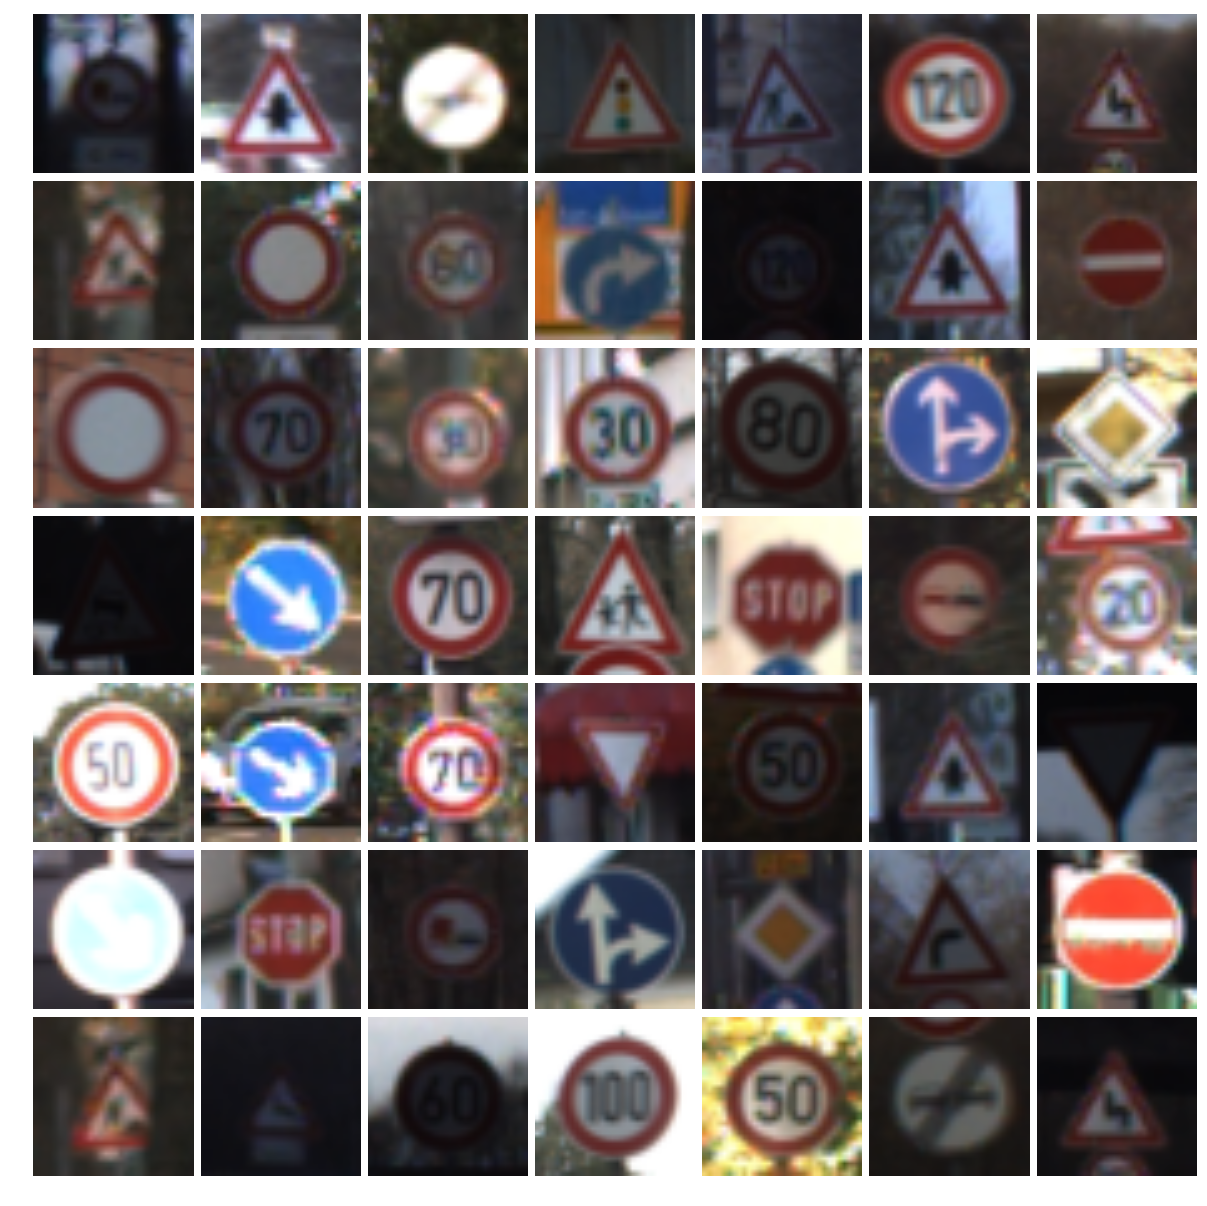

In [440]:
# plot the first 49 images in the training dataset
fig, axs = plt.subplots(7, 7, figsize = (15, 15))
fig.subplots_adjust(hspace = .05, wspace = .05)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[i])
    ax.axis("off")
#fig.savefig('training_image.png')
plt.show

<function matplotlib.pyplot.show>

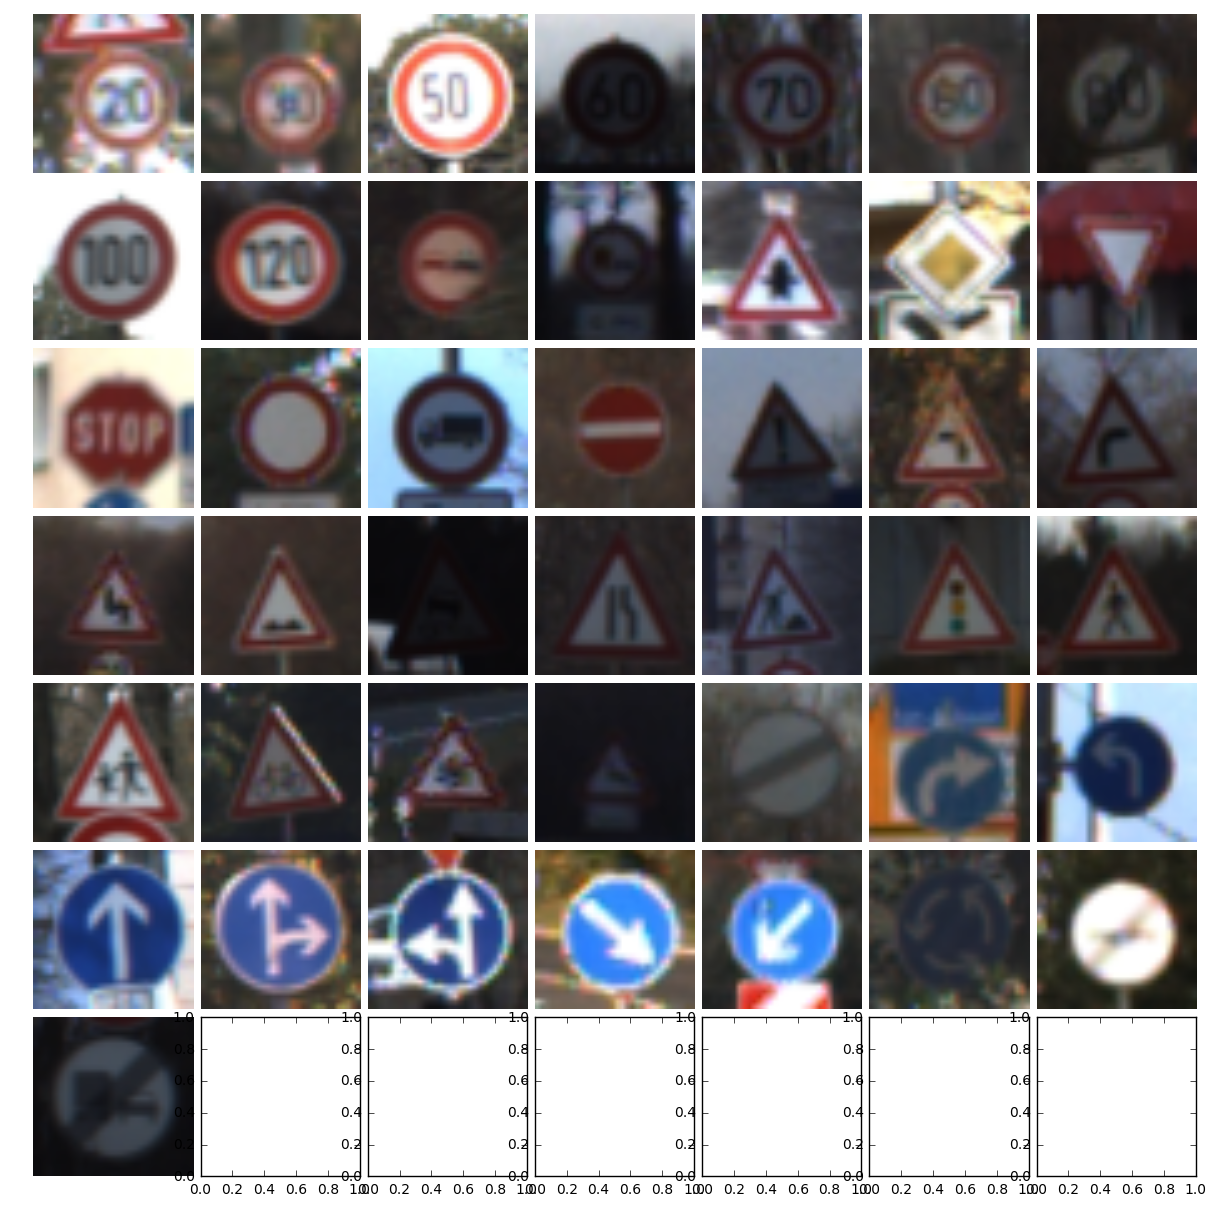

In [442]:
# plot one image for each label in the training dataset
fig, axs = plt.subplots(7, 7, figsize = (15, 15))
fig.subplots_adjust(hspace = .05, wspace = .05)
for i, ax in enumerate(axs.flatten()):
    if i < n_classes:
        index = y_train.tolist().index(i)
        ax.imshow(X_train[index])
        ax.axis("off")
#fig.savefig('image_of_each_label.png')
plt.show

<function matplotlib.pyplot.show>

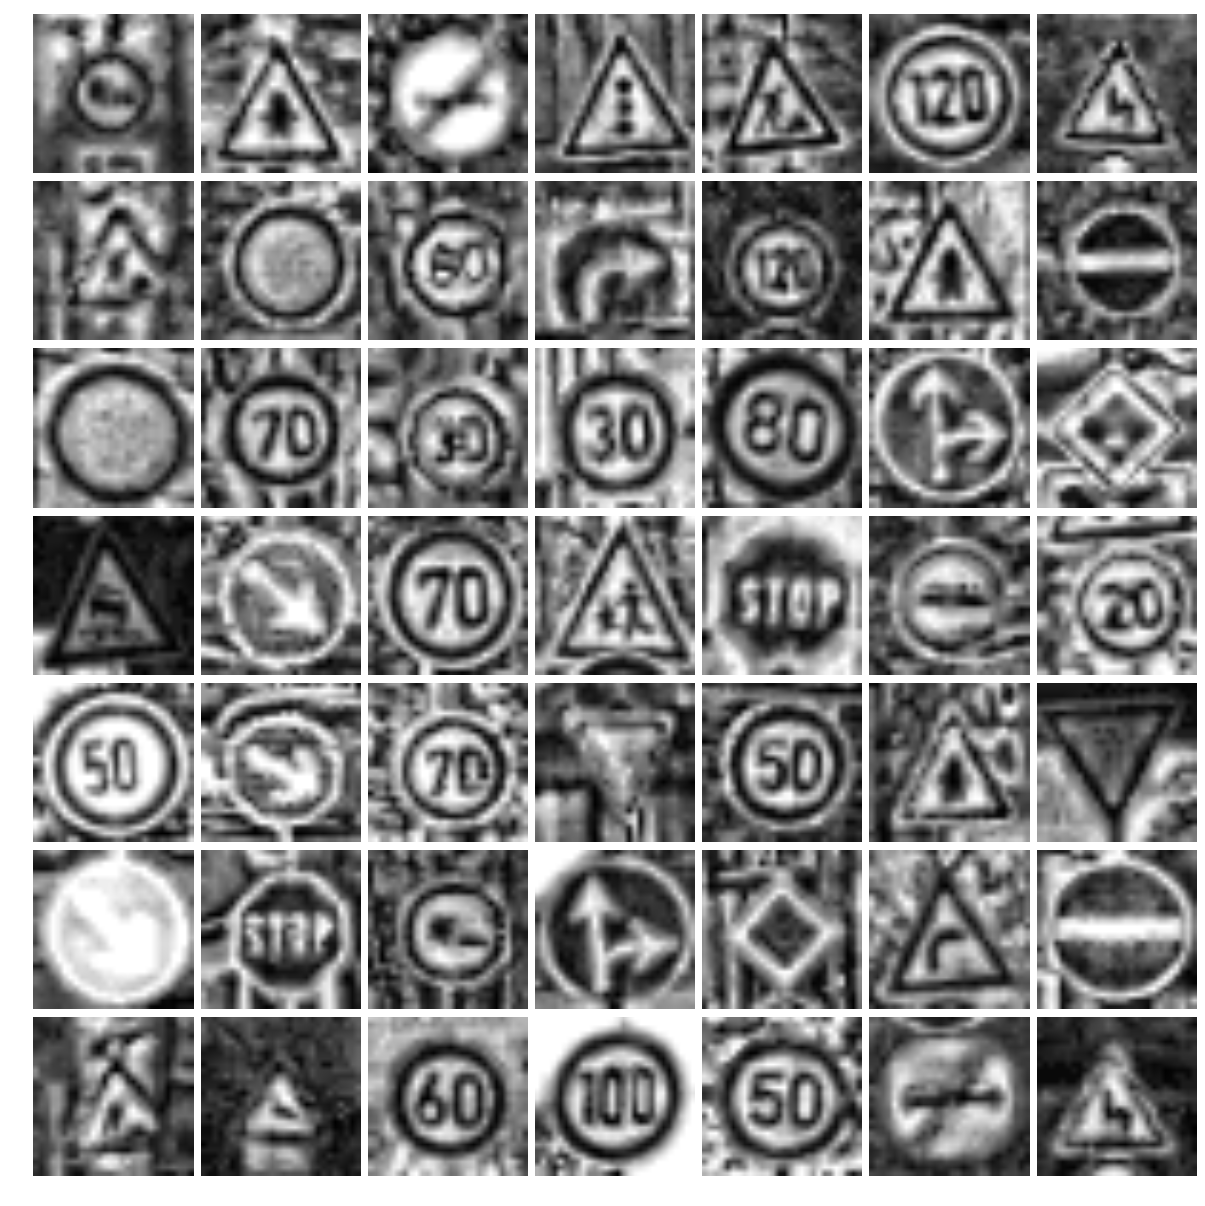

In [454]:
# plot the first 49 images in the training dataset
fig, axs = plt.subplots(7, 7, figsize = (15, 15))
fig.subplots_adjust(hspace = .05, wspace = .05)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train_N[i], cmap='gray')
    ax.axis("off")
#fig.savefig('training_image.png')
plt.show

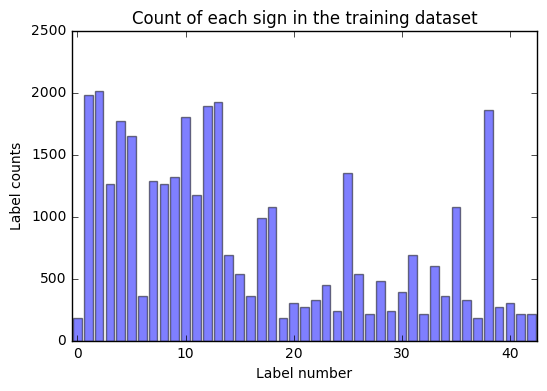

In [446]:
# plot the count of each sign in the training dataset
unique_label, counts_label = np.unique(y_train, return_counts=True)
plt.bar(unique_label, counts_label, align='center', alpha=0.5)
#plt.xticks(unique_label, objects)
plt.xlim(-0.5, 42.5)
plt.ylabel('Label counts')
plt.xlabel('Label number')
plt.title('Count of each sign in the training dataset')

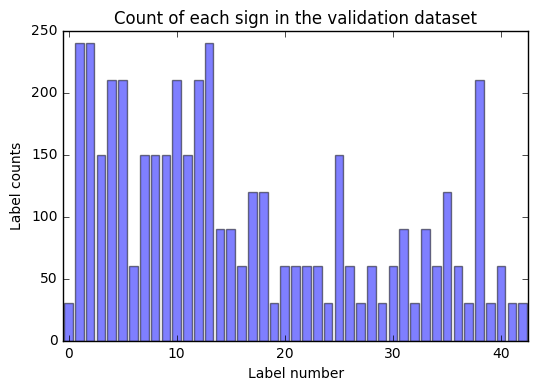

In [447]:
# plot the count of each sign in the validation dataset
unique_label, counts_label = np.unique(y_valid, return_counts=True)
plt.bar(unique_label, counts_label, align='center', alpha=0.5)
#plt.xticks(unique_label, objects)
plt.xlim(-0.5, 42.5)
plt.ylabel('Label counts')
plt.xlabel('Label number')
plt.title('Count of each sign in the validation dataset')

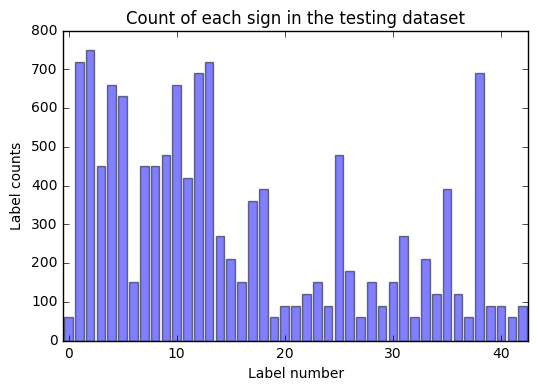

In [448]:
# plot the count of each sign in the testing dataset
unique_label, counts_label = np.unique(y_test, return_counts=True)
plt.bar(unique_label, counts_label, align='center', alpha=0.5)
#plt.xticks(unique_label, objects)
plt.xlim(-0.5, 42.5)
plt.ylabel('Label counts')
plt.xlabel('Label number')
plt.title('Count of each sign in the testing dataset')

----

## Step 2: Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

In [456]:
def normalized_pixel(x):
    return 2.0*x/256.-1.

In [457]:
X_train_N = normalized_pixel(X_train_1[:, 2:30, 2:30].astype('float32'))
X_valid_N = normalized_pixel(X_valid_1[:, 2:30, 2:30].astype('float32'))
X_test_N = normalized_pixel(X_test_1[:, 2:30, 2:30].astype('float32'))

In [458]:
X_train_N.shape

(34799, 28, 28)

### Model Architecture

#### The model is modified from the classical LeNet-5 CNN.  The model architecture is listed in the following table
| Layers       | Size         | Activation   |
|:------------:|:------------:|:------------:|
|Input|28x28x1||
|Cov1|28x28x6, same padding|elu|
|Max pooling|14x14x6||
|Cov2|14x14x16, same padding|elu|
|Max pooling|7x7x16||
|L1, fully connected| 784|elu|
|Dropout|||
|L2, fully connected| 400|elu|
|Dropout|||
|L3, fully connected| 43| softmax_cross_entropy|


In [494]:
# Hyperparameters
mu = 0
sigma = 0.1
drop_out_prob = 0.6

In [495]:
# Features and Labels
features = tf.placeholder(tf.float32, [None, 28, 28])
labels = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

In [496]:
input_layer = tf.reshape(features, [-1, 28, 28, 1])
# SOLUTION: Layer 1: Convolutional. Input = 28x28x1. Output = 28x28x1x6.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(6))
conv1   = tf.nn.conv2d(input_layer, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

# Activation.
conv1 = tf.nn.elu(conv1)

# Pooling. Input = 28x28x1x6. Output = 14x14x1x6.
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Layer 2: Convolutional. Output = 14x14x1x16.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b

# Activation.
conv2 = tf.nn.elu(conv2)

# Pooling. Input = 14x14x16. Output = 7x7x16.
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Flatten. Input = 7x7x16. Output = 784.
fc0   = tf.reshape(conv2,[tf.shape(conv2)[0], 784])

# Layer 3: Fully Connected. Input = 784. Output = 400.
fc1_W = tf.Variable(tf.truncated_normal(shape=(784, 400), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(400))
fc1   = tf.matmul(fc0, fc1_W) + fc1_b

# Activation.
fc1    = tf.nn.elu(fc1)

# Dropout
fc1 = tf.nn.dropout(fc1, keep_prob)

# Layer 4: Fully Connected. Input = 300. Output = 120.
fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(120))
fc2    = tf.matmul(fc1, fc2_W) + fc2_b

# Activation.
fc2    = tf.nn.elu(fc2)

# Dropout
fc2 = tf.nn.dropout(fc2, keep_prob)

# Layer 5: Fully Connected. Input = 120. Output = n_classes.
fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(n_classes))
logits = tf.matmul(fc2, fc3_W) + fc3_b

### Train, Validate and Test the Model

In [506]:
# this is essentially the one-hot encoder, which is later replaced with a self-defined function.
lb = preprocessing.LabelBinarizer()
train_label = lb.fit_transform(y_train).astype('float32')
valid_label = lb.fit_transform(y_valid).astype('float32')
test_label = lb.fit_transform(y_test).astype('float32')

In [498]:
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    outout_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches

In [499]:
def print_epoch_stats(epoch_i, sess, last_features, last_labels):
    """
    Print cost, training accuracy, and validation accuracy of an epoch
    """
    current_cost = sess.run(
        cost,
        feed_dict={features: last_features, labels: last_labels, keep_prob: 1.0})
    train_accuracy = sess.run(
        accuracy,
        feed_dict={features: last_features, labels: last_labels, keep_prob: 1.0})
    valid_accuracy = sess.run(
        accuracy,
        feed_dict={features: X_valid_N, labels: valid_label, keep_prob: 1.0})
    print('Epoch: {:<4} - Cost: {:<8.3} Train Accuracy: {:<5.3} Valid Accuracy: {:<5.3}'.format(
        epoch_i,
        current_cost,
        train_accuracy,
        valid_accuracy))
    return current_cost, train_accuracy, valid_accuracy

In [501]:
batch_size = 128
epochs = 50
learn_rate = 0.0006

In [502]:
# Define loss and optimizer
learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Calculate accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

train_batches = batches(batch_size, X_train_N, train_label)
saver = tf.train.Saver()

In [503]:
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch_i in range(epochs):

        # Loop over all batches
        for batch_features, batch_labels in train_batches:
            train_feed_dict = {
                features: batch_features,
                labels: batch_labels,
                learning_rate: learn_rate,
                keep_prob: drop_out_prob}
            sess.run(optimizer, feed_dict=train_feed_dict)

        # Print cost and validation accuracy of an epoch
        current_cost, train_accuracy, valid_accuracy = print_epoch_stats(epoch_i, sess, batch_features, batch_labels)
        # save data to file
    save_path = saver.save(sess, "./CNN_LeNet_preprocess_2.ckpt")

Epoch: 0    - Cost: 0.602    Train Accuracy: 0.82  Valid Accuracy: 0.778
Epoch: 1    - Cost: 0.273    Train Accuracy: 0.955 Valid Accuracy: 0.86 
Epoch: 2    - Cost: 0.152    Train Accuracy: 0.928 Valid Accuracy: 0.893
Epoch: 3    - Cost: 0.111    Train Accuracy: 0.964 Valid Accuracy: 0.897
Epoch: 4    - Cost: 0.0828   Train Accuracy: 0.991 Valid Accuracy: 0.913
Epoch: 5    - Cost: 0.0418   Train Accuracy: 0.982 Valid Accuracy: 0.921
Epoch: 6    - Cost: 0.0973   Train Accuracy: 0.991 Valid Accuracy: 0.919
Epoch: 7    - Cost: 0.046    Train Accuracy: 0.991 Valid Accuracy: 0.926
Epoch: 8    - Cost: 0.0774   Train Accuracy: 0.991 Valid Accuracy: 0.932
Epoch: 9    - Cost: 0.0533   Train Accuracy: 0.991 Valid Accuracy: 0.929
Epoch: 10   - Cost: 0.021    Train Accuracy: 1.0   Valid Accuracy: 0.934
Epoch: 11   - Cost: 0.0201   Train Accuracy: 0.991 Valid Accuracy: 0.932
Epoch: 12   - Cost: 0.0325   Train Accuracy: 0.982 Valid Accuracy: 0.934
Epoch: 13   - Cost: 0.0104   Train Accuracy: 1.0   

In [514]:
# Check the model accuracy using the test dataset
with tf.Session() as sess:
    saver.restore(sess, "./CNN_LeNet_preprocess_2.ckpt")
    test_accuracy = sess.run(
        accuracy,
        feed_dict={features: X_test_N, labels: test_label, keep_prob: 1.0})
print('Test Accuracy: {:<5.3}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./CNN_LeNet_preprocess_2.ckpt
Test Accuracy: 0.953


---

## Step 3: Test a Model on New Images

To provide more insight into how the model is working, six pictures of German traffic signs from the web are downloaded to predict the traffic sign type.

The six pictures are downloaded from google image. The images are cropped so that the traffic sign is centered in a squred image.

In [709]:
# load the new testing images
def read_image(path):
    data = []
    files = glob.glob(path)
    # prepare training dataset for non-cars
    for i in files:
        image = cv2.imread(i)
        data.append(cv2.resize(image, (28, 28)))
    data = np.array(data)
    return data

In [729]:
# The new images are briefly cropped and centered. They are saved in the folder "Test_image"
test_path = os.getcwd() + '/Test_image/*.png'
X_new = read_image(test_path)

<function matplotlib.pyplot.show>

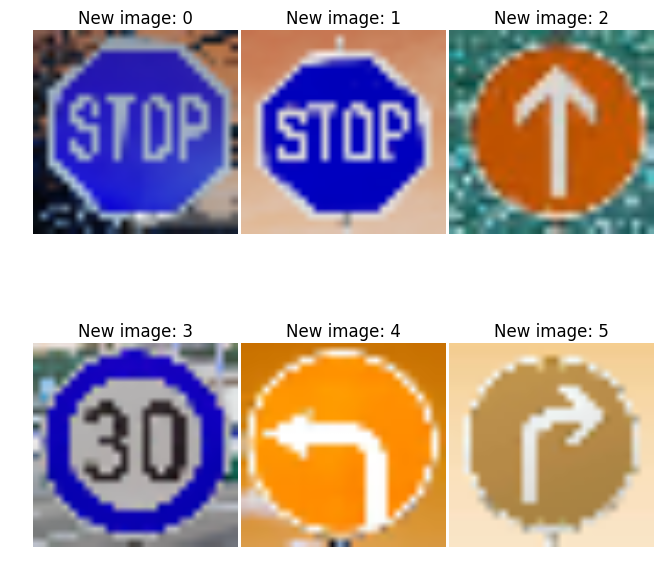

In [731]:
# see the new images after resize into 28 x 28
fig, axs = plt.subplots(2, 3, figsize = (8, 8))
fig.subplots_adjust(hspace = .02, wspace = .02)
for i, ax in enumerate(axs.flatten()):
    if i < 6:
        ax.set_title("New image: " + str(i))
        ax.imshow(X_new[i])
        ax.axis("off")       
#fig.savefig('new_image.png')
plt.show

### Load and Output the Images

In [732]:
# process the new images in the same way as the training/validation/test dataset
X_new = preprocessing(X_new)
X_new_N = normalized_pixel(X_new.astype('float32'))

In [734]:
X_new.shape

(6, 28, 28)

### Predict the Sign Type for Each Image

In [704]:
# Check the corresponding label of the seven testing label in the csv file 
sign_csv_path = os.getcwd() + '/signnames.csv'
sign_names = pd.read_csv(sign_csv_path)
sign_names

ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                               Stop
15       15                                        No vehicles
16       16           Vehicles over 3.5 metric tons prohibited
17       17                                           No entry
18       18                                    General caution
19       19                        Dangerous curve to the left
20       20                       Dangerous curve to the right
21       21                                       Double curve
22       22                                         Bumpy road
23       23                                      Slippery road
24       24                          Road narrows on the right
25       25                                          Road work
26       26                                    Traffic signals
27       27                                        Pedestrians
28       28                                  Children crossing
29       29                                  Bicycles crossing
30       30                                 Beware of ice/snow
31       31                              Wild animals crossing
32       32                End of all speed and passing limits
33       33                                   Turn right ahead
34       34                                    Turn left ahead
35       35                                         Ahead only
36       36                               Go straight or right
37       37                                Go straight or left
38       38                                         Keep right
39       39                                          Keep left
40       40                               Roundabout mandatory
41       41                                  End of no passing
42       42  End of no passing by vehicles over 3.5 metric ...

### Analyze Performance

In [705]:
### Calculate the accuracy for these 6 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [706]:
def one_hot_encode(x, class_number=43):
    y = np.zeros((len(x), class_number))
    for i in range(len(x)):
        y[i, x[i]] = 1
    return y.astype('float32')

In [736]:
# create the label for the seven new images
y_new = [14, 14, 35, 1, 34, 33]
new_label = one_hot_encode(y_new, 43)

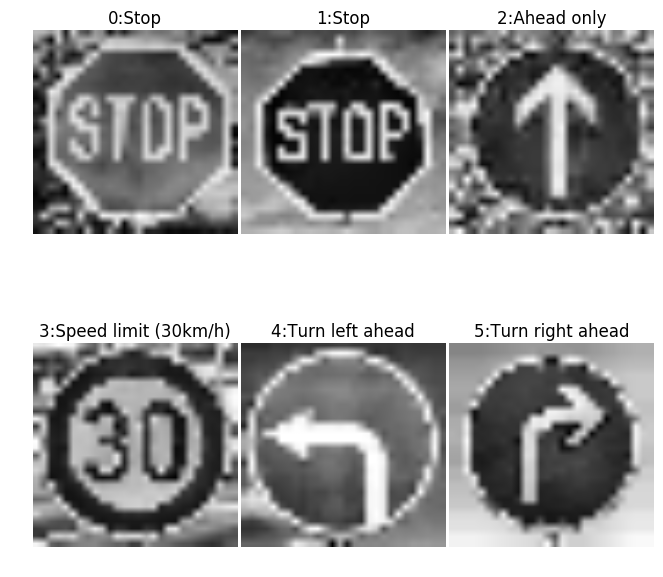

In [764]:
# see the new images after preprocessing and normalization into 28 x 28, with the corrected label
fig, axs = plt.subplots(2, 3, figsize = (8, 8))
fig.subplots_adjust(hspace = .02, wspace = .02)
for i, ax in enumerate(axs.flatten()):
    if i < 6:
        ax.set_title(str(i) + ':' + sign_names['SignName'][y_new[i]])
        ax.imshow(X_new[i], cmap = 'gray')
        ax.axis("off")
#fig.savefig('new_image_with_label.png')

In [746]:
### Run the predictions here and use the model to output the prediction for each image.
# Check the model accuracy using the test dataset
prob = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, "./CNN_LeNet_preprocess_2.ckpt")
    test_accuracy = sess.run(
        accuracy,
        feed_dict={features: X_new_N, labels: new_label, keep_prob: 1.0})
    Z = logits.eval(feed_dict={features: X_new_N, labels: new_label, keep_prob: 1.0})
    probability = prob.eval(feed_dict={features: X_new_N, labels: new_label, keep_prob: 1.0})
    y_pred = np.argmax(Z, axis = 1)
print('Test Accuracy on new image downloaded from web: {:<5.3}'.format(test_accuracy))


INFO:tensorflow:Restoring parameters from ./CNN_LeNet_preprocess_2.ckpt
Test Accuracy on new image downloaded from web: 1.0  


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). 

In [787]:
# apply the tf.nn.top_k function to output the top-5 probability and corresponding indices
with tf.Session() as sess:
    top_5 = sess.run(tf.nn.top_k(tf.constant(probability), k = 5))

In [793]:
print ('Top 5 probability for the new images are: \n')
print (top_5.values)
print ('\nThe corresponding top 5 indices are: \n')
print (top_5.indices)

Top 5 probability for the new images are: 

[[  1.00000000e+00   9.33778836e-12   3.05446484e-14   1.23494820e-15
    7.64655711e-16]
 [  1.00000000e+00   1.36326512e-16   6.48527220e-22   3.19586928e-27
    1.80095924e-27]
 [  1.00000000e+00   3.76448005e-14   1.24131843e-17   3.41005642e-18
    2.52136231e-18]
 [  1.00000000e+00   2.61017562e-11   1.44488837e-12   2.09982246e-13
    3.56522571e-14]
 [  1.00000000e+00   9.54270517e-12   1.86211367e-14   2.57236842e-17
    1.58388802e-19]
 [  9.99978185e-01   2.17704783e-05   1.80723003e-09   1.30102248e-11
    1.77761787e-12]]

The corresponding top 5 indices are: 

[[14 17  1  4 33]
 [14 17 33 32  1]
 [35 33 37 34 18]
 [ 1  5  4  2  7]
 [34 38 17 13 35]
 [33 15  4 35 16]]


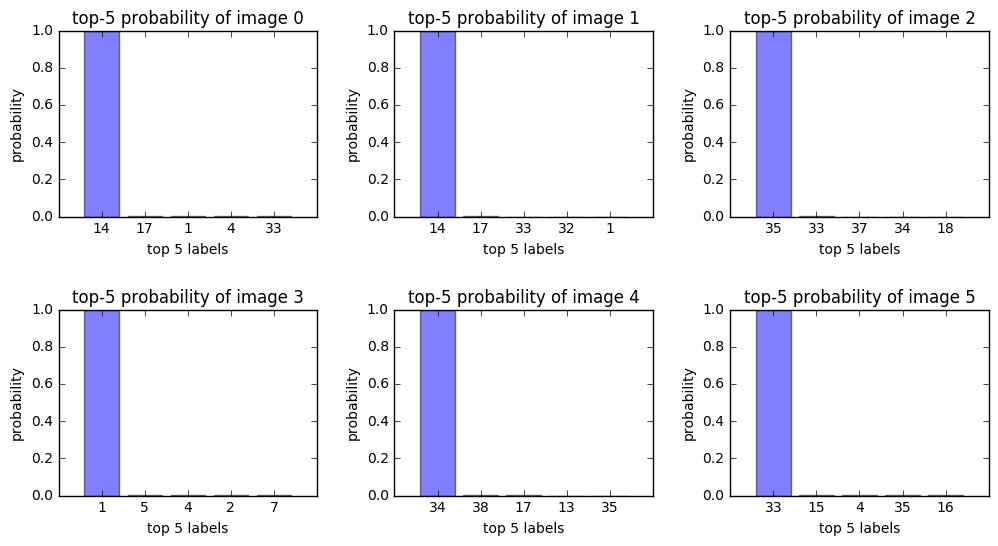

In [789]:
# Visualization of the top 5 probability and indices in the bar graph
fig, axs = plt.subplots(2, 3, figsize = (12, 6))
fig.subplots_adjust(hspace = .5, wspace = .3)
for i, ax in enumerate(axs.flatten()):
    if i < 6:
        ax.set_title('top-5 probability of image '+str(i))
        ax.bar(y_pos, top_5.values[i], align='center', alpha=0.5)
        plt.sca(ax)
        plt.xticks(y_pos, top_5.indices[i])
        plt.ylabel('probability')
        plt.xlabel('top 5 labels')
        #plt.title('')
#fig.savefig('new_image_with_label.png')

---

##  Visualize the Neural Network's State with Test Images


In [873]:
# Visualization the six feature maps of the six new images
def plot_features(x, size = 8, hspace = 0.1):
    fig, axs = plt.subplots(x.shape[0], x.shape[3], figsize = (size, size))
    fig.subplots_adjust(hspace = .01, wspace = .01)
    for i, ax in enumerate(axs.flatten()):
        if i < x.shape[3]:
            ax.set_title('f ' + str(i))
        ax.imshow(x[int(i/x.shape[3]),:,:, i%x.shape[3]], interpolation="nearest", cmap="gray")
        if i%x.shape[3] == 0:
            ax.set_ylabel('i ' + str(int(i/x.shape[3])))
        #ax.axis("off")
        #ax.axis("off")
        ax.set_yticks([])
        ax.set_xticks([])

INFO:tensorflow:Restoring parameters from ./CNN_LeNet_preprocess_2.ckpt


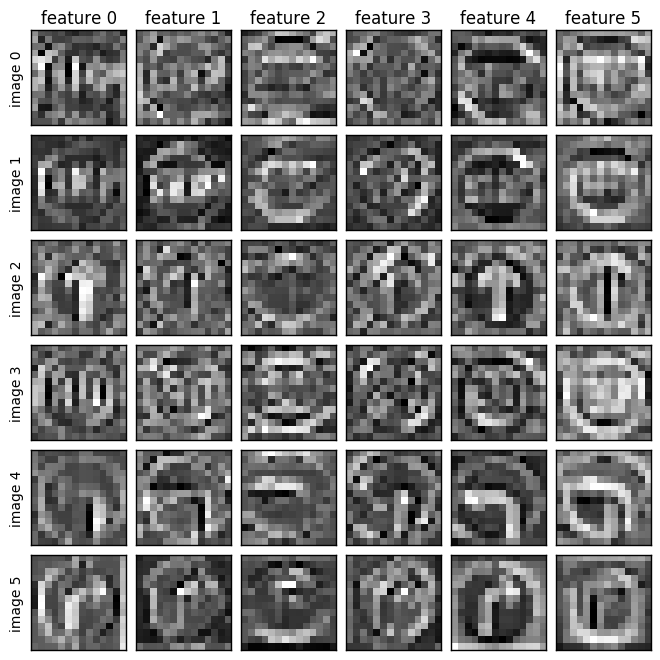

In [851]:
# Save the feature map of Conv1 layer after max pooling
with tf.Session() as sess:
    saver.restore(sess, "./CNN_LeNet_preprocess_2.ckpt")
    feature_map_conv1 = conv1.eval(session=sess,feed_dict={features: X_new_N})
    plot_features(feature_map_conv1)

INFO:tensorflow:Restoring parameters from ./CNN_LeNet_preprocess_2.ckpt


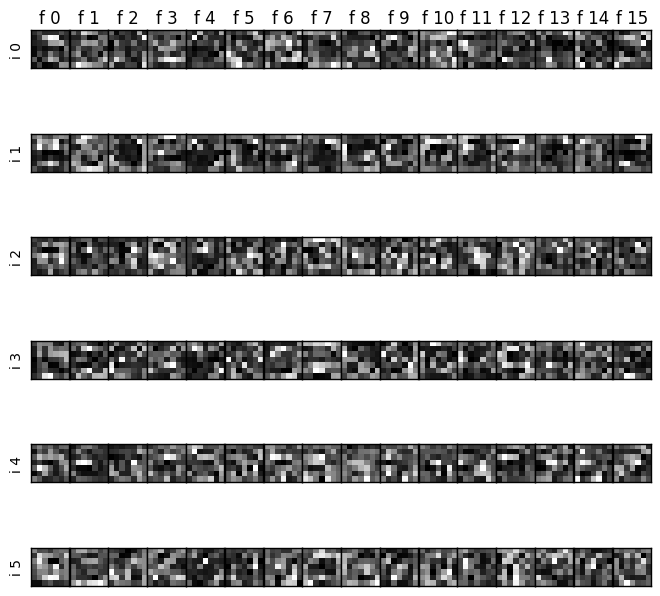

In [874]:
# Save the feature map of Conv2 layer after max pooling
with tf.Session() as sess:
    saver.restore(sess, "./CNN_LeNet_preprocess_2.ckpt")
    feature_map_conv2 = conv2.eval(session=sess,feed_dict={features: X_new_N})
    plot_features(feature_map_conv2, 8, 0.01)